## Baseline solution

The baseline solution is the Additive Noise Model (ANM) from the [causal discovery toolbox](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html).

<img src="https://github.com/MEDI-FAIR/competition-public-files/raw/main/anm.png" width=800 ALIGN="center" style='margin-right:10px; border-style: solid; border-width: 2px;' alt='anm'>

This method assumes that the noise in the data is additive.
It uses a non-linear regression model to try to estimate the data generating process in both directions, calculate the residuals, then test the independance of the residuals from the data.

https://proceedings.neurips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf

It is not a very sophisticated method, but it is a good starting point for developing a more sophisticated solution.

In [1]:
!pip install cdt seaborn==0.12.0 tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 KB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=5ad7c092f04ee9bb138e7194905fa2b616c346f7ca6b7ef14c94cecad5c94d1f
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29269 sha256=ef2a18cc91960bccf3680da4a2dd6525cabd0a898ebb3df4651e091db11c93da
  Stored in directory: /root/.cache/pip/wheels/f3/a1/a2/a4a90339e8fe767416385d9aabc02ab731fa14d55ce7694a33
Successfully built GPUtil skrebate
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cdt.causality.pairwise import ANM, CDS
from tqdm.notebook import tqdm
tqdm.pandas()

Detecting 1 CUDA device(s).


In [3]:
!rm -rf starting_kit*

In [4]:
!wget -O starting_kit.zip https://www.codabench.org/datasets/download/aec2852c-b6ab-4652-90c0-bcf28f4a21dc/

--2023-03-26 00:04:52--  https://www.codabench.org/datasets/download/aec2852c-b6ab-4652-90c0-bcf28f4a21dc/
Resolving www.codabench.org (www.codabench.org)... 129.175.22.233
Connecting to www.codabench.org (www.codabench.org)|129.175.22.233|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://miniodis-rproxy.lisn.upsaclay.fr/coda-v2-prod-private/dataset/2023-03-07-1678213029/f98e0918f36d/starting_kit.zip?AWSAccessKeyId=EASNOMJFX9QFW4QIY4SL&Signature=CjHubyTR8kUovuq2R8Yuc3DE7mA%3D&Expires=1679875494 [following]
--2023-03-26 00:04:55--  https://miniodis-rproxy.lisn.upsaclay.fr/coda-v2-prod-private/dataset/2023-03-07-1678213029/f98e0918f36d/starting_kit.zip?AWSAccessKeyId=EASNOMJFX9QFW4QIY4SL&Signature=CjHubyTR8kUovuq2R8Yuc3DE7mA%3D&Expires=1679875494
Resolving miniodis-rproxy.lisn.upsaclay.fr (miniodis-rproxy.lisn.upsaclay.fr)... 129.175.8.8
Connecting to miniodis-rproxy.lisn.upsaclay.fr (miniodis-rproxy.lisn.upsaclay.fr)|129.175.8.8|:443... connected.
HT

In [5]:
!wget -O public_data.zip https://www.codabench.org/datasets/download/aafd38ea-cb96-47b6-be2e-e0fbacbb2bcb/

--2023-03-26 00:04:57--  https://www.codabench.org/datasets/download/aafd38ea-cb96-47b6-be2e-e0fbacbb2bcb/
Resolving www.codabench.org (www.codabench.org)... 129.175.22.233
Connecting to www.codabench.org (www.codabench.org)|129.175.22.233|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://miniodis-rproxy.lisn.upsaclay.fr/coda-v2-prod-private/dataset/2023-03-05-1678032644/7e70a7261e3c/public_data.zip?AWSAccessKeyId=EASNOMJFX9QFW4QIY4SL&Signature=bgxmcg6MKn%2FM5IwS8kVPGxmZlt8%3D&Expires=1679875498 [following]
--2023-03-26 00:04:58--  https://miniodis-rproxy.lisn.upsaclay.fr/coda-v2-prod-private/dataset/2023-03-05-1678032644/7e70a7261e3c/public_data.zip?AWSAccessKeyId=EASNOMJFX9QFW4QIY4SL&Signature=bgxmcg6MKn%2FM5IwS8kVPGxmZlt8%3D&Expires=1679875498
Resolving miniodis-rproxy.lisn.upsaclay.fr (miniodis-rproxy.lisn.upsaclay.fr)... 129.175.8.8
Connecting to miniodis-rproxy.lisn.upsaclay.fr (miniodis-rproxy.lisn.upsaclay.fr)|129.175.8.8|:443... connected.


Here is a very simple and intuitive example of causal estimation. Here, the data is generated using a polynomial function, with a random noise added to it. The ANM is able to recover the causal direction of the relationship between X and Y.

In [6]:
!unzip starting_kit.zip
!unzip public_data.zip

Archive:  starting_kit.zip
   creating: starting_kit/
   creating: starting_kit/sample_data/
  inflating: starting_kit/sample_data/X_sample_info.csv  
  inflating: starting_kit/sample_data/X_sample.csv  
  inflating: starting_kit/anm.png    
 extracting: starting_kit/sample_submission_full_set.zip  
   creating: starting_kit/sample_submission_sample_data/
  inflating: starting_kit/sample_submission_sample_data/results.csv  
  inflating: starting_kit/logo.png   
 extracting: starting_kit/sample_submission_sample_data.zip  
  inflating: starting_kit/Starting_Kit.ipynb  
   creating: starting_kit/sample_submission_full_set/
  inflating: starting_kit/sample_submission_full_set/results.csv  
Archive:  public_data.zip
   creating: public_data/
   creating: public_data/train_set/
  inflating: public_data/train_set/X_train_info.csv  
  inflating: public_data/train_set/y_train.csv  
  inflating: public_data/train_set/X_train.csv  
  inflating: public_data/README.txt  
 extracting: public_data/t

In [7]:
data_path = 'public_data/train_set/X_train.csv'
target_path = 'public_data/train_set/y_train.csv'

In [8]:
# Load the validation data
X_train = pd.read_csv(data_path, index_col=0)
X_train

,A,B
SampleID,,
train1,-6348 4599 -9340 -13170 8456 -10079 -68 7957 ...,6 7 6 7 7 7 7 7 1 7 7 7 1 7 7 7 7 3 3 7 7 7 6...
train2,-6462 7666 19406 -2299 -22045 -6262 24734 -88...,3 4 5 5 5 4 3 7 4 5 5 4 1 5 4 4 5 4 5 5 5 5 5...
train3,12800 -6791 -539 -9092 9818 1646 13806 324 -6...,-7469 38799 -6292 2224 -11357 -10823 -8578 -5...
train4,14 580 -6627 10738 13938 -13793 -17467 -1269 ...,11883 -82 -3086 3150 -7775 -5290 1338 8765 52...
train5,1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1...
...,...,...
train4046,4357 5081 8462 -2377 -12335 -9462 -8831 -1333...,-2732 -4691 8332 7864 6218 -7947 -8314 13878 ...
train4047,-2907 9751 14806 2 -17031 -399 11194 -10194 -...,1804 12086 -1686 10098 -8410 -7808 -6720 -289...
train4048,1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0...,0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0...


In [9]:
y_train = pd.read_csv(target_path, index_col=0)
y_train

,Target
SampleID,
train1,0
train2,1
train3,1
train4,1
train5,0
...,...
train4046,0
train4047,0
train4048,0


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4050 entries, train1 to train4050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A       4050 non-null   object
 1   B       4050 non-null   object
dtypes: object(2)
memory usage: 94.9+ KB


The data is a list of pairs. Right now the data points are stored as strings, so we need to convert them to a list of numbers.

In [11]:
convert = lambda x: np.array([float(i) for i in x.split(' ')[1:]])
X_train["A"] = X_train["A"].apply(convert)
X_train["B"] = X_train["B"].apply(convert)
X_train

,A,B
SampleID,,
train1,"[-6348.0, 4599.0, -9340.0, -13170.0, 8456.0, -...","[6.0, 7.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 1.0, ..."
train2,"[-6462.0, 7666.0, 19406.0, -2299.0, -22045.0, ...","[3.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, 7.0, 4.0, ..."
train3,"[12800.0, -6791.0, -539.0, -9092.0, 9818.0, 16...","[-7469.0, 38799.0, -6292.0, 2224.0, -11357.0, ..."
train4,"[14.0, 580.0, -6627.0, 10738.0, 13938.0, -1379...","[11883.0, -82.0, -3086.0, 3150.0, -7775.0, -52..."
train5,"[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
train4046,"[4357.0, 5081.0, 8462.0, -2377.0, -12335.0, -9...","[-2732.0, -4691.0, 8332.0, 7864.0, 6218.0, -79..."
train4047,"[-2907.0, 9751.0, 14806.0, 2.0, -17031.0, -399...","[1804.0, 12086.0, -1686.0, 10098.0, -8410.0, -..."
train4048,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


Here, we plot some causal pairs along with their target

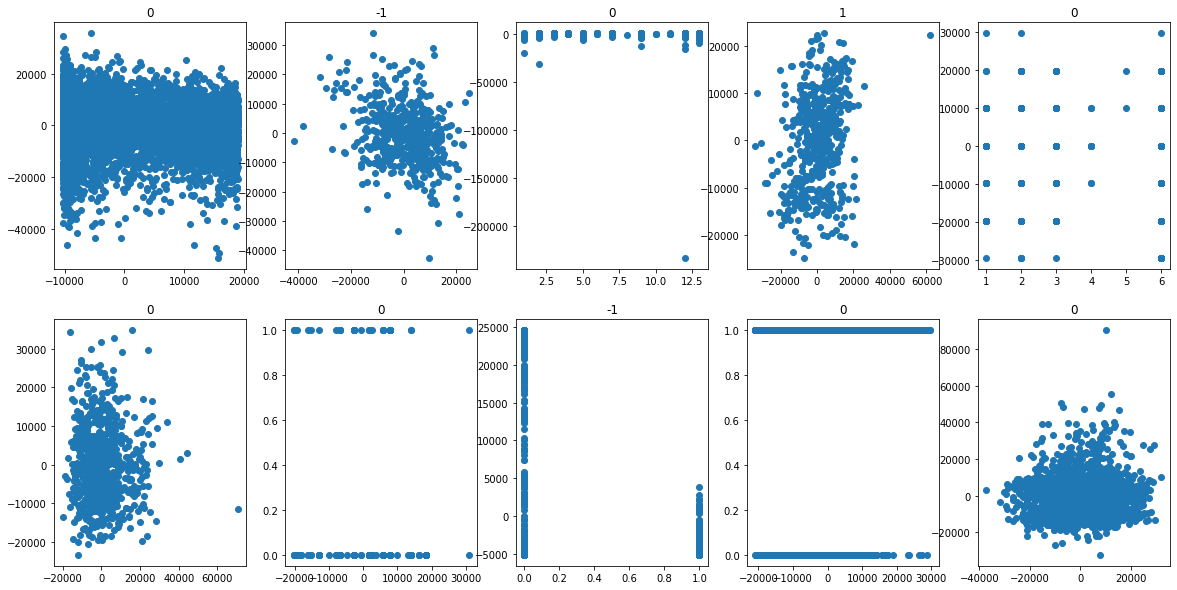

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i // 5, i % 5].scatter(X_train["A"][i+10], X_train["B"][i+10])
    axs[i // 5, i % 5].set_title(y_train['Target'][i+10])
plt.show()

<Axes: ylabel='Frequency'>

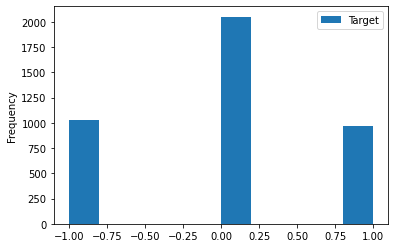

In [13]:
y_train.plot(kind='hist')

In [14]:
X_train['A'].apply(len).describe()

count    4050.000000
mean     2424.150617
std      2056.261529
min        53.000000
25%       782.250000
50%      1629.500000
75%      3624.750000
max      7998.000000
Name: A, dtype: float64

In [15]:
X_train['B'].apply(len).describe()

count    4050.000000
mean     2424.150617
std      2056.261529
min        53.000000
25%       782.250000
50%      1629.500000
75%      3624.750000
max      7998.000000
Name: B, dtype: float64

In [16]:
X_train.isna().sum()

A    0
B    0
dtype: int64

Some of these pairs have a massive ammount of points.

We are going to downsample those have have more than 600 points, down to 600 points. We might lose information, but it will make the computation of the ANM faster. Computing the ANM without downsampling on the **full** validation set would take hours, but with downsampling it took about 15 minutes on Google Colab.

In [17]:
X_train_downsampled = X_train.copy()

In [18]:
def downsample_row(row):
  if len(row.A) > 600:
    indices = np.random.choice(len(row.A), size=600, replace=False)
    rowcopy = row.copy()
    rowcopy.A = rowcopy.A[indices]
    rowcopy.B = rowcopy.B[indices]
    
    return rowcopy
  return row

In [19]:
X_train_downsampled = X_train_downsampled.progress_apply(downsample_row, axis=1)

  0%|          | 0/4050 [00:00<?, ?it/s]

In [20]:
X_train_downsampled.A.apply(len).describe()

count    4050.000000
mean      580.573086
std        66.307539
min        53.000000
25%       600.000000
50%       600.000000
75%       600.000000
max       600.000000
Name: A, dtype: float64

In [21]:
X_train_downsampled

,A,B
SampleID,,
train1,"[-6348.0, 4599.0, -9340.0, -13170.0, 8456.0, -...","[6.0, 7.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 1.0, ..."
train2,"[3472.0, -10035.0, -21873.0, 7194.0, -1083.0, ...","[5.0, 5.0, 4.0, 1.0, 7.0, 4.0, 1.0, 1.0, 5.0, ..."
train3,"[-7567.0, 3027.0, -7955.0, -1940.0, -8963.0, 5...","[134.0, -13461.0, 1396.0, -4371.0, 14717.0, -1..."
train4,"[19195.0, -13927.0, -1209.0, -8218.0, 6816.0, ...","[6809.0, -6639.0, 2992.0, -350.0, -4237.0, 242..."
train5,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
train4046,"[6033.0, 12471.0, 13872.0, 10321.0, -325.0, -1...","[9956.0, 10253.0, 6626.0, 3316.0, -7831.0, 433..."
train4047,"[-2907.0, 9751.0, 14806.0, 2.0, -17031.0, -399...","[1804.0, 12086.0, -1686.0, 10098.0, -8410.0, -..."
train4048,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Let's compute the ANM on the downsampled set.

In [22]:
anm = ANM()

In [23]:
def score_pair(row):
    a_to_b = anm.anm_score(row["A"].reshape(-1, 1), row["B"])
    b_to_a = anm.anm_score(row["B"].reshape(-1, 1), row["A"])
    return b_to_a - a_to_b

In [24]:
# apply score_pair to each row of the dataframe
res = X_train_downsampled.progress_apply(score_pair, axis=1)

  0%|          | 0/4050 [00:00<?, ?it/s]

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
overflow encountered in exp
invalid value encountered in reduce
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in true_divide
Mean of empty slice.
invalid value encountered in double_scalars
overflow encountered in exp
invalid value encountered in reduce
invalid value encountered in true_divide
Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in true_divide
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in true_

In [25]:
res

SampleID
train1       -0.132177
train2       -0.523363
train3        1.162430
train4        0.032303
train5      -15.769264
               ...    
train4046     0.039562
train4047    -0.090747
train4048    -0.087725
train4049     0.231572
train4050     0.250653
Length: 4050, dtype: float64

In [26]:
(res.values>0).sum()

2019

In [27]:
(res.values<0).sum()

2026

In [28]:
(res.values==0).sum() # samples with no additive noise

5

### Splitting the samples between numerical and categorical

In [65]:
y_train.loc['train5'].values[0]

0

In [66]:
categorical_data = pd.DataFrame(columns = ['A', 'B', 'Target']).rename_axis('SampleID')

for index, row in X_train_downsampled.iterrows():
  if row.A.min()==0 and row.A.max()==1:
    categorical_data.loc[row.name] = [row.A, row.B, y_train.loc[row.name].values[0]]
categorical_data

,A,B,Target
SampleID,,,
train5,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0
train18,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[-2825.0, -4551.0, -5089.0, -3896.0, -4193.0, ...",-1
train26,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[7441.0, -13793.0, 8375.0, 6082.0, 6251.0, 105...",1
train28,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[4015.0, 6622.0, -14650.0, 5218.0, -1126.0, -1...",0
train50,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[-3219.0, -4851.0, 3656.0, 10772.0, 540.0, 371...",0
...,...,...,...
train3985,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-1822.0, -1813.0, -5579.0, 9594.0, -2836.0, -...",-1
train3995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[5688.0, 5271.0, 6701.0, 6605.0, 3751.0, 6100....",-1
train4013,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[9237.0, 464.0, -7489.0, -2273.0, 2050.0, -127...",0


In [74]:
numerical_data = X_train_downsampled.drop(categorical_data.index)
numerical_data['Target'] = y_train['Target'].loc[numerical_data.index].values

numerical_data

,A,B,Target
SampleID,,,
train1,"[-6348.0, 4599.0, -9340.0, -13170.0, 8456.0, -...","[6.0, 7.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 1.0, ...",0
train2,"[3472.0, -10035.0, -21873.0, 7194.0, -1083.0, ...","[5.0, 5.0, 4.0, 1.0, 7.0, 4.0, 1.0, 1.0, 5.0, ...",1
train3,"[-7567.0, 3027.0, -7955.0, -1940.0, -8963.0, 5...","[134.0, -13461.0, 1396.0, -4371.0, 14717.0, -1...",1
train4,"[19195.0, -13927.0, -1209.0, -8218.0, 6816.0, ...","[6809.0, -6639.0, 2992.0, -350.0, -4237.0, 242...",1
train6,"[2.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 2.0, 3.0, ...","[-1705.0, -772.0, 4741.0, 3431.0, -8435.0, -64...",1
...,...,...,...
train4045,"[-8676.0, 11167.0, -10182.0, 9831.0, 3296.0, -...","[-5104.0, -1679.0, 1746.0, 10309.0, -10242.0, ...",1
train4046,"[6033.0, 12471.0, 13872.0, 10321.0, -325.0, -1...","[9956.0, 10253.0, 6626.0, 3316.0, -7831.0, 433...",0
train4047,"[-2907.0, 9751.0, 14806.0, 2.0, -17031.0, -399...","[1804.0, 12086.0, -1686.0, 10098.0, -8410.0, -...",0


### Visualizing the target values of categorical vs numerical values

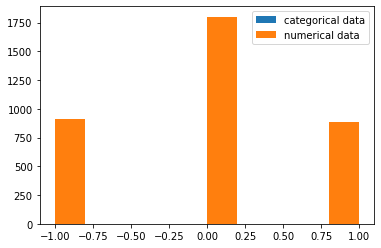

In [80]:
plt.hist(categorical_data['Target'], label='categorical data')
plt.hist(numerical_data['Target'], label='numerical data')

plt.legend(loc='upper right')
plt.show()

The 2 datasets have the same distribution of target values

### Testing with Logistic Regression Classifier on numerical data

In [85]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(numerical_data[['A', 'B']], numerical_data['Target'], test_size=0.2)

x_train.shape, x_valid.shape

((2877, 2), (720, 2))

In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_valid, y_valid)

ValueError: ignored



---





---



---



We save the results in a csv file, and zip it.

**You might need to change the zip command depending on your OS.**

In [ ]:
# output_path = 'starting_kit/sample_submission_sample_data/'

In [ ]:
# res.rename("Target").to_csv(output_path + "results.csv", header=True)

In [ ]:
# execute this to create a zip file for submission. you might need to change the command depending on your OS

# !cd sample_submission && zip -r submission.zip results.csv

/bin/bash: line 0: cd: sample_submission: No such file or directory


If using the full validation set instead of the sample data, the submission.zip is ready to be submitted on Codabench.